## 11. XGBoost Outlier Detection (XGBOD)

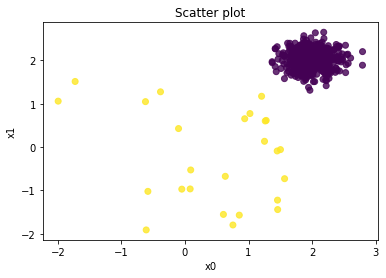

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [7]:
from pyod.models.xgbod import XGBOD
xgbod = XGBOD(n_components=4,random_state=100) 
xgbod.fit(X_train,y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = xgbod.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = xgbod.decision_scores_  # raw outlier scores
y_train_scores = xgbod.decision_function(X_train)
# get the prediction on the test data
y_test_pred = xgbod.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = xgbod.decision_function(X_test)  # outlier scores

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

/Users/chriskuo/opt/anaconda3/envs/AD/lib/python3.9/site-packages/pyod/models/base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/Users/chriskuo/opt/anaconda3/envs/AD/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "n_components", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The training data: {0.0: 475, 1.0: 25}
The training data: {0.0: 475, 1.0: 25}


In [8]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Pred': y_test_pred})
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0.0,1.0
Actual,,
0.0,475,0
1.0,0,25


In [9]:
xgbod.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'estimator_list': [KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=1, novelty=True, p=2),
  KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=3, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=3, novelty=True, p=2),
  KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
    metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
    radius=1.0),
  LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    metric_params=None, 

In [10]:
# Let's see how many '0's and '1's.
df_train = pd.DataFrame(X_train)
df_columns = df_train.columns
df_train['pred'] = y_train_pred
df_train['Group'] = np.where(df_train['pred']==1, 'Outlier','Normal')

# Now let's show the summary statistics:
cnt = df_train.groupby('Group')['pred'].count().reset_index().rename(columns={'pred':'Count'})
cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
stat = df_train.groupby('Group').mean().reset_index() # The avg.
cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together

,Group,Count,Count %,0,1,2,3,4,5,pred
0,Normal,475,95.0,2.003067,2.011302,2.006399,1.991409,2.008367,1.984887,0.0
1,Outlier,25,5.0,0.453548,-0.209294,-0.474818,-0.231157,-0.034642,-0.055947,1.0
